In [1]:
# Librerias utilizadas en los codigos

from statsbombpy import sb
import pandas as pd
from mplsoccer import VerticalPitch,Pitch
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import Rectangle, FancyBboxPatch, Circle, FancyArrowPatch
from collections import Counter
import textwrap
import os
import base64
import requests
from io import BytesIO
from dotenv import load_dotenv
from IPython.display import Image, display
from matplotlib.cm import get_cmap
from textwrap import fill
from sklearn.cluster import KMeans
from matplotlib.patches import Rectangle, FancyBboxPatch, FancyArrowPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
import matplotlib.image as mpimg

In [2]:
# Cargar los archivos necesarios
input_path = Path("../data") / "database_v5.csv"
df = pd.read_csv(input_path, low_memory=False)

In [3]:
# Cargar clave API desde .env
ruta_env = Path("../env") / "TFM_Tactics.env"
load_dotenv(dotenv_path=ruta_env)

api_key = os.getenv("OPENAI_API_KEY")

In [4]:
# Prompt generado automáticamente basado en datos
def prompt_formacion_tactica(equipo, match_id, formacion, competicion="Bundesliga 2023/2024"):
    texto = f"""
Actúa como un analista táctico profesional de fútbol. La imagen proporcionada muestra la formación táctica del equipo {equipo}
durante el partido con ID {match_id} en la {competicion}.

La estructura detectada automáticamente es: {formacion} (jugadores por línea defensiva, media y ofensiva).

A partir de la imagen, analiza:
1. Qué tipo de formación representa (por ejemplo: 4-2-3-1, 3-4-3, etc.).
2. Qué estilo de juego sugiere esta disposición (presión alta, repliegue, amplitud...).
3. Fortalezas y debilidades de esta estructura.
4. Posibles mejoras de la estructura.

Responde como un informe técnico profesional en máximo 8 líneas.
"""
    return texto

# Crear imagen de red de pases y devolver base64
def imagen_base64_formacion(df, match_id, equipo="Bayer Leverkusen", texto_ia="[Análisis táctico IA pendiente]"):
    from io import BytesIO
    import base64

    # Generar el gráfico completo con la función actualizada
    fig = grafico_formacion_tactica(df, match_id, equipo=equipo, texto_ia=texto_ia)

    # Guardar como imagen en memoria y codificar en base64
    buf = BytesIO()
    fig.savefig(buf, format='png', bbox_inches='tight', dpi=150)
    plt.close(fig)
    img_base64 = base64.b64encode(buf.getvalue()).decode('utf-8')

    return img_base64

# Enviar a OpenAI GPT-4o con imagen base64
def analizar_formacion(base64_image, prompt, modelo="gpt-4o"):
    url = "https://api.openai.com/v1/chat/completions"
    headers = {
        "Authorization": f"Bearer {api_key}",
        "Content-Type": "application/json"
    }
    body = {
        "model": modelo,
        "messages": [
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {
                            "url": f"data:image/png;base64,{base64_image}"
                        }
                    },
                    {
                        "type": "text",
                        "text": prompt
                    }
                ]
            }
        ],
        "temperature": 0.7
    }

    response = requests.post(url, headers=headers, json=body)
    if response.status_code == 200:
        return response.json()["choices"][0]["message"]["content"]
    else:
        raise Exception(f"Error: {response.status_code} - {response.text}")

In [5]:
def grafico_formacion_tactica(df, match_id, equipo="Bayer Leverkusen", texto_ia="[Análisis táctico IA pendiente]"):

    df = df.copy()

    if 'location_x' not in df.columns or 'location_y' not in df.columns:
        df['location'] = df['location'].apply(lambda x: eval(x) if isinstance(x, str) else x)
        df = df[df['location'].apply(lambda x: isinstance(x, list) and len(x) == 2)]
        df[['location_x', 'location_y']] = pd.DataFrame(df['location'].tolist(), index=df.index)

    df_match = df[(df['match_id'] == match_id) & (df['team'] == equipo)]
    if df_match.empty:
        raise ValueError("No hay datos de este equipo para el partido.")

    info = df[df['match_id'] == match_id].dropna(subset=['home_team', 'away_team', 'home_score', 'away_score', 'match_date']).iloc[0]
    home, away, fecha = info['home_team'], info['away_team'], str(info['match_date'])
    rival = away if equipo == home else home

    # Seleccionar 11 jugadores y posiciones medias
    top_players = df_match['player'].value_counts().nlargest(11).index
    posiciones = df_match[df_match['player'].isin(top_players)].groupby("player")[["location_x", "location_y"]].mean()

    # KMeans por línea táctica (horizontal)
    portero = posiciones['location_x'].idxmin()
    posiciones['linea'] = -1
    posiciones.loc[portero, 'linea'] = 0

    otros = posiciones.drop(index=portero)
    kmeans = KMeans(n_clusters=3, random_state=0).fit(otros[['location_x']])
    orden = np.argsort(kmeans.cluster_centers_.flatten())
    label_map = {label: i + 1 for i, label in enumerate(orden)}
    for idx, jugador in enumerate(otros.index):
        posiciones.loc[jugador, 'linea'] = label_map[kmeans.labels_[idx]]

    colores_linea = {0: 'gray', 1: 'red', 2: 'orange', 3: 'green'}

    # Crear figura
    fig = plt.figure(figsize=(16, 10), facecolor='white')
    gs = fig.add_gridspec(3, 3, width_ratios=[3, 0.1, 1.2], height_ratios=[4, 1.9, 0.2])
    ax1, ax2, ax3 = fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0:2, 2]), fig.add_subplot(gs[1, 0])

    # Fondo decorativo
    bg_ax = fig.add_axes([0, 0, 1, 1], zorder=-1)
    bg_ax.axis("off")
    bg_ax.add_patch(FancyBboxPatch((0, 0), 1, 1, transform=fig.transFigure,
                                   boxstyle="round,pad=0.01", facecolor='white',
                                   edgecolor="black", linewidth=1.5, zorder=-1))

    for ax in [ax1, ax2, ax3]:
        ax.set_facecolor('white')
    ax3.set_facecolor('lightgrey')
    ax2.axis('off')
    ax3.axis('off')

    # Campo
    Pitch(pitch_type='statsbomb', pitch_color=None, line_color='black', linewidth=1).draw(ax=ax1)
    ax1.set_xlim(0, 120)
    ax1.set_ylim(80, 0)
    ax1.axis('off')
    ax1.set_title(f"{home} vs {away}", fontsize=14, weight='bold')

    # Jugadores
    for player, fila in posiciones.iterrows():
        color = colores_linea.get(int(fila['linea']), 'black')
        ax1.scatter(fila['location_x'], fila['location_y'], s=300, color=color, edgecolors='black', zorder=3)
        ax1.text(fila['location_x'], fila['location_y'] - 2, player.split()[-1], ha='center', va='bottom',
                 fontsize=9, weight='bold', color='black', zorder=4)

    # Panel lateral (ax2)
    home_team = df_match['home_team'].iloc[0]
    away_team = df_match['away_team'].iloc[0]
    minuto_final = df_match['minute'].max()
    segundo_final = int(df_match[df_match['minute'] == minuto_final]['second'].max())

    if minuto_final > 90:
        texto_periodo = "Final del partido"
    elif minuto_final > 45:
        texto_periodo = "Segunda mitad"
    else:
        texto_periodo = "Primera mitad"

    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.text(0.5, 0.95, fecha, ha="center", fontsize=10, weight='bold')
    ax2.text(0.5, 0.91, texto_periodo, ha="center", fontsize=10)
    ax2.text(0.5, 0.88, f"{minuto_final}:{segundo_final:02d}", ha="center", fontsize=22, weight='bold')
    ax2.add_patch(Rectangle((0.35, 0.82), 0.1, 0.05, color='black'))
    ax2.add_patch(Rectangle((0.55, 0.82), 0.1, 0.05, color='black'))
    ax2.text(0.4, 0.845, str(info['home_score']), color='white', ha='center', va='center', fontsize=16)
    ax2.text(0.6, 0.845, str(info['away_score']), color='white', ha='center', va='center', fontsize=16)
    ax2.text(0.01, 0.81, '\n'.join(textwrap.wrap(home_team, width=15)), color="red", fontsize=10, ha="left", weight="bold")
    ax2.text(0.99, 0.81, '\n'.join(textwrap.wrap(away_team, width=15)), color="blue", fontsize=10, ha="right", weight="bold")

    # ----------- TABLA TÁCTICA (AX2) -------------
    conteo_lineas = posiciones['linea'].value_counts().to_dict()
    promedio_altura = posiciones.groupby('linea')['location_y'].mean().round(1).to_dict()
    jugador_adelantado = posiciones['location_x'].idxmax()

    stats_info = {
        "Portero:": portero,
        "Bloque defensivo:": f"{conteo_lineas.get(1, 0)} jugadores",
        "Bloque medio:": f"{conteo_lineas.get(2, 0)} jugadores",
        "Bloque ofensivo:": f"{conteo_lineas.get(3, 0)} jugadores",
        "Altura media defensa:": promedio_altura.get(1, "-"),
        "Altura media medio:": promedio_altura.get(2, "-"),
        "Altura media ataque:": promedio_altura.get(3, "-"),
        "Jugador más adelantado:": jugador_adelantado
    }

    y_tabla = 0.73
    dy = 0.042
    for i, (label, value) in enumerate(stats_info.items()):
        y = y_tabla - i * dy
        ax2.add_patch(Rectangle((0, y - 0.032), 1, dy, color="#f0f0f0" if i % 2 == 0 else "white", zorder=0))
        ax2.text(0.02, y, label, ha="left", va="center", fontsize=9, weight="bold", zorder=1)
        ax2.text(0.98, y, str(value), ha="right", va="center", fontsize=9, zorder=1)

    # Panel IA (ax3)
    texto_ia = "\n".join([fill(line.strip(), width=112) for line in texto_ia.splitlines()]).replace("**", "")
    ax3.set_xlim(0, 1)
    ax3.set_ylim(0, 1)
    ax3.add_patch(Rectangle((0, 0), 1, 1, transform=ax3.transAxes, color="lightgrey",
                            zorder=0, linewidth=1.2, edgecolor="black"))
    ax3.text(0.05, 0.95, "Análisis táctico IA", fontsize=10, weight="bold", va="top")
    ax3.text(0.05, 0.82, texto_ia, fontsize=8, va="top", ha="left", linespacing=1, wrap=True, family="monospace")

    fig.subplots_adjust(wspace=0.03, hspace=0.001, top=0.98, bottom=0.02)
    return fig

In [6]:
def detectar_formacion_ordenada(df, match_id, equipo="Bayer Leverkusen"):
    from sklearn.cluster import KMeans
    import numpy as np
    from collections import Counter

    df = df.copy()

    # Filtrar solo por partido y equipo (sin filtrar por tipo de evento)
    df_match = df[(df['match_id'] == match_id) & (df['team'] == equipo)]
    if df_match.empty:
        raise ValueError("No hay datos disponibles para este partido y equipo.")

    top_players = df_match['player'].value_counts().nlargest(11).index
    posiciones = df_match[df_match['player'].isin(top_players)].groupby("player")[["location_x", "location_y"]].mean()

    portero = posiciones['location_x'].idxmin()
    otros = posiciones.drop(index=portero)

    kmeans = KMeans(n_clusters=3, random_state=0).fit(otros[['location_x']])
    centers = kmeans.cluster_centers_.flatten()
    orden = np.argsort(centers)
    label_map = {original: i + 1 for i, original in enumerate(orden)}
    lineas = [label_map[kmeans.labels_[i]] for i in range(len(otros))]

    conteo = Counter(lineas)
    formacion_str = "-".join(str(conteo[i]) for i in sorted(conteo))

    return formacion_str

In [7]:
def analisis_formacion_completo(df, match_id, equipo="Bayer Leverkusen"):

    # Detectar formación automática y generar prompt
    formacion = detectar_formacion_ordenada(df, match_id, equipo)
    prompt = prompt_formacion_tactica(equipo=equipo, match_id=match_id, formacion=formacion)

    # Generar imagen base64 sin análisis aún (solo para enviar a la API)
    placeholder = "[Análisis táctico IA pendiente]"
    img_b64 = imagen_base64_formacion(df, match_id, equipo, texto_ia=placeholder)

    # Enviar imagen + prompt a la IA y obtener respuesta
    texto_ia = analizar_formacion(img_b64, prompt)

    # Generar gráfico final con el texto IA incluido
    fig = grafico_formacion_tactica(df, match_id, equipo=equipo, texto_ia=texto_ia)

    return fig, texto_ia, prompt

  File "C:\Users\blope\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\blope\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\blope\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\blope\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^



Actúa como un analista táctico profesional de fútbol. La imagen proporcionada muestra la formación táctica del equipo Bayer Leverkusen
durante el partido con ID 3895052 en la Bundesliga 2023/2024.

La estructura detectada automáticamente es: 3-3-4 (jugadores por línea defensiva, media y ofensiva).

A partir de la imagen, analiza:
1. Qué tipo de formación representa (por ejemplo: 4-2-3-1, 3-4-3, etc.).
2. Qué estilo de juego sugiere esta disposición (presión alta, repliegue, amplitud...).
3. Fortalezas y debilidades de esta estructura.
4. Posibles mejoras de la estructura.

Responde como un informe técnico profesional en máximo 8 líneas.



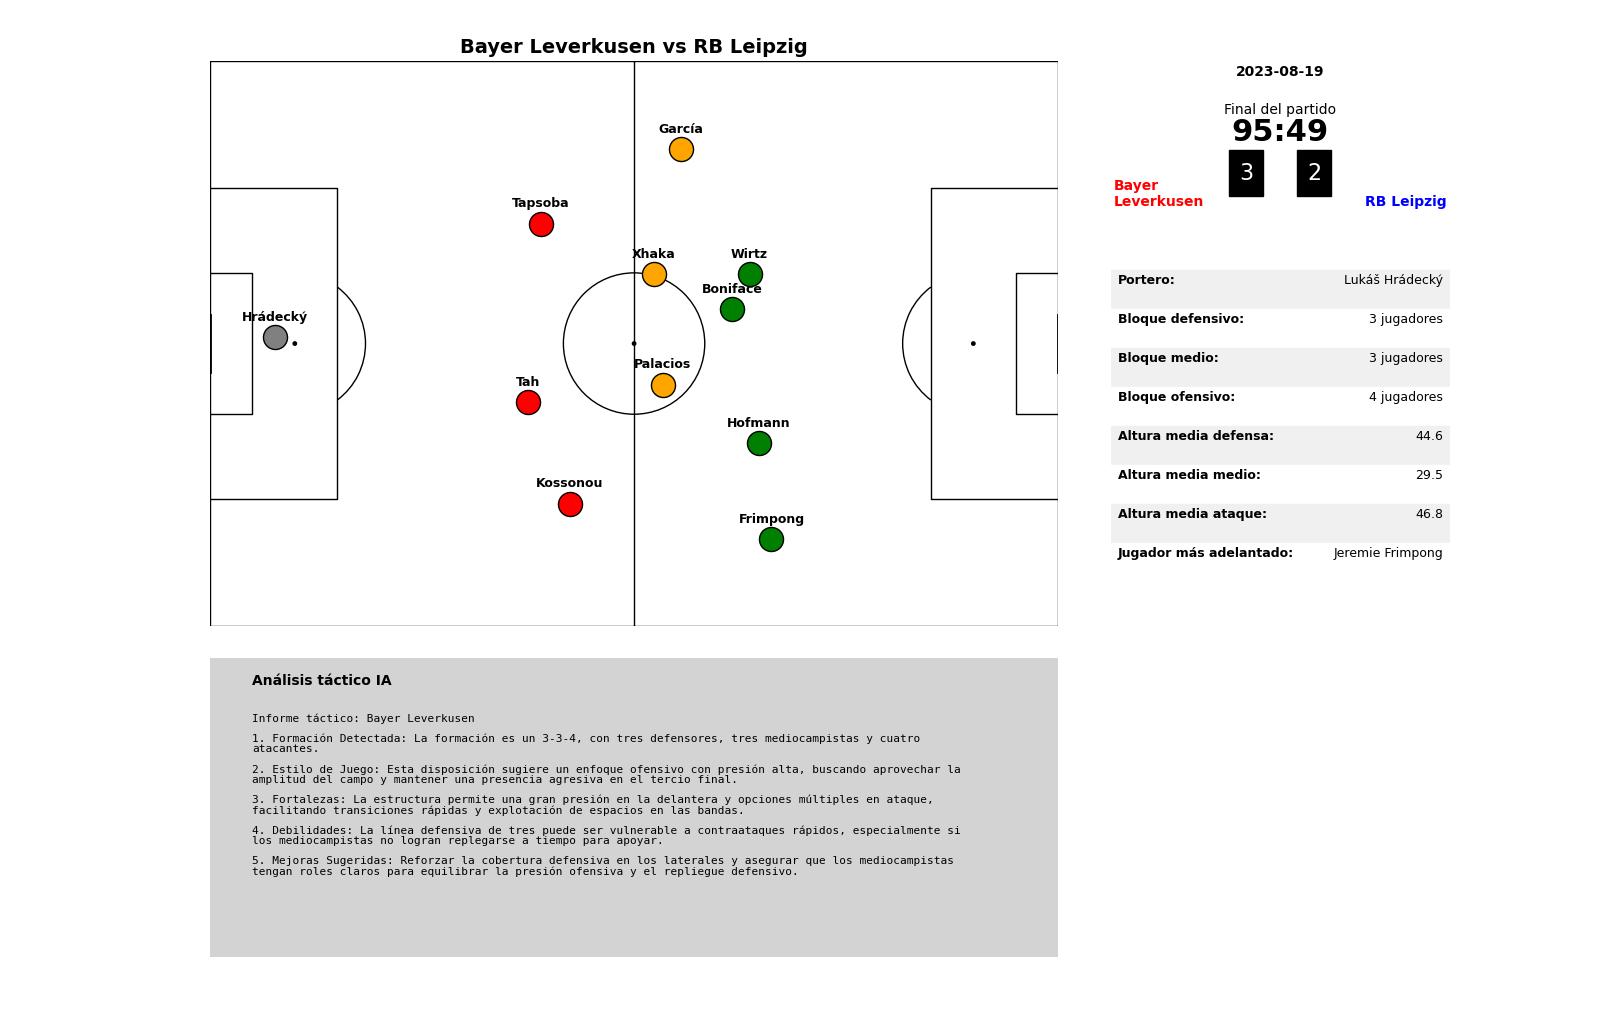

In [8]:
match_id = 3895052
equipo = "Bayer Leverkusen"

fig, texto_ia, prompt = analisis_formacion_completo(df, match_id=match_id, equipo=equipo)
# Crear ruta de salida
output_path = Path("../figs/kmeans_formacion") / f"kmeans_formacion_{match_id}.png"
output_path.parent.mkdir(parents=True, exist_ok=True)

fig.savefig(output_path, dpi=300, bbox_inches='tight')

print(prompt)

img_base64 = imagen_base64_formacion(df, match_id=match_id, equipo=equipo)

output_path = Path("../figs/kmeans_formacion") / f"imagen_base64_kmeans_formacion_{match_id}.png"
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, "wb") as f:
    f.write(base64.b64decode(img_base64))